![Funcional Health Tech](logo.png "Logo")

**COVID19 - Análise do Surto Brasileiro**

# Modelo Epidemiológico Clássico: SEIR

Neste documento investigamos a dinâmica epidemiológica da COVID19 empregando um modelo cĺássico conhecido como SEIR e algumas variações imediatas. Uma vez definido o modelo, empregamos dados históricos para estimar seus parâmetros para o caso brasileiro. Essas estimativas são usadas então para gerar dois conjuntos de dados simulados: sem e com medidas de miticação. Esses dois resultados são salvos em arquivos CSV para uso posterior em outras análises.

Esta implementação serve como base para investigações mais profundas, e pode ser customizada e usado de diversos modos por eventuais interessados. É possível, por exemplo, experimentar com medidas de mitigação diferentes.



**ADVERTÊNCIA:** os modelos e números aqui apresentados não são afirmações formais sobre o progresso da doença, mas apenas exercícios que demonstram técnicas de modelagem e cenários de aplicação.

## Preliminares
Bibliotecas, configurações e parâmetros.

In [1]:
import os
import math
import hyperopt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]
import seaborn as sns
sns.set()

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
plt.style.use('fivethirtyeight')

E uma função para auxiliar no desenho de gráficos.

In [3]:
def plot_simulation_output(df_simulated_data, zoom_on=None, zoom_length=60):
    df_simulated_data = df_simulated_data[['S', 'E', 'I', 'R', 'E+I']]
    
    ax = sns.lineplot(data=df_simulated_data)
    ax.set_title('Visão Geral da Epidemia')
    plt.figure()
    
    ax = sns.lineplot(data=df_simulated_data[['E', 'I', 'E+I']])
    ax.set_title('Apenas Expostos e Infectados')
    plt.figure()
    
    if zoom_on is not None:
        zoom_end = (pd.Timestamp(zoom_on) + pd.DateOffset(days=zoom_length)).date()
        ax = sns.lineplot(data=df_simulated_data[['E', 'I', 'E+I']][zoom_on:zoom_end], markers=True)
        ax.set_title(f'Zoom (de {zoom_on} a {zoom_end})')
        plt.figure()

## Parâmetros das Simulações

Empregaremos simulações para efetivamente executar os modelos que serão desenvolvidos abaixo. Para tanto, é necessário definir-se alguns parâmetros gerais.

Data de início da epidemia.

In [4]:
epidemic_start_date = pd.Timestamp(2020, 3, 12)

Quantida de dias.

In [5]:
epidemic_duration_in_days = 365

Tamanho da população.

In [6]:
population_size = 200 * 1e6 #18000000

Infectados inicialmente.

In [7]:
initially_infected = 52

Finalmente, onde queremos armazenar resultados do modelo para posterior.

In [8]:
results_folder = '../results/'

## Modelo SEIR

O [modelo SEIR](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology) é um dos modos clássicos de se representar a dinâmica de epidemias. Trata-se de um chamado "modelo de compartimento", no qual temos alguns compartimentos principais:

  - S(t): número de indivíduos suscetíveis em função do tempo.
  - E(t): número de expostos, mas ainda não transmissores, em função do tempo.
  - I(t): número de indivíduos infectados e transmissores em função do tempo.
  - R(t): número de indivíduos que se recuperam em função do tempo.
  
São também necessários dois outros parâmetros, que definem taxas de transição entre compartimentos:
  
  - beta: valor entre 0.0 e 1.0 que define a taxa de S para E (i.e., taxa de exposição)
  - alpha: valor entre 0.0 e 1.0 que define a taxa de E para I (i.e., taxa de contaminação)
  - gamma: valor entre 0.0 e 1.0 que define a taxa de I para R (i.e., taxa de recuperação)

Tradicionalmente, esse modelo é tratado via equações diferenciais. Aqui, adotaremos uma implementação via simulações estocásticas, o que nos permitirá posteriormente realizar modificações variadas que talvez não sejam tratáveis analiticamente.

### Funções Auxiliares

Antes de prosseguir, vamos definir algumas funções auxliares que garantirão que os valores acrescidos ou subtraídos nos diversos compartimentos não ultrapassem valores limites.

In [9]:
def aux_enforce_max_addition(Q, delta):
    if Q - delta <= 0:
        return Q
    
    else:
        return delta
    
def aux_enforce_max_removal(Q, delta):
    if Q + delta <= 0:
        return -Q
    else:
        return delta

Ao longo de uma epidemia, é razoável supor que autoridades sanitárias e, de fato, a polulação como um todo, adotarão medidas que possam reduzir o contágio e melhorar as chances de recuperação. Isso pode ser modelado com parâmetros dinâmicos, supondo-se intervenções em momentos precisos do tempo. Assim, os parâmetros do modelo aqui proposto podem ser tanto escalares quanto dicionários que mapeiam instantes a valores naqueles instantes. Para que a simulação possa usar transparentemente qualquer caso, definimos a seguir uma função que extrai o valor do parâmetro conforme o caso.

In [10]:
def param_at(param_var, t):
    if isinstance(param_var, dict):
        return param_var[t]
    
    else:
        return param_var

Convém também ter uma função para montar as sequências de parâmetros (veremos um exemplo mais adiante para entender seu uso).

In [11]:
def dynamic_parameter(regimens, min_length):
    i = 0
    params = {}
    last_value = None
    for value, length in regimens:
        param = {t: value for t in range(i, i + length)}
        params.update(param)
        i += length
        last_value = value
    
    # if we do not have enough data, fill in the remaining entries with the last specified value
    if i < min_length:
        param = {t: last_value for t in range(i, i + min_length)}
        params.update(param)

    return params

### Funções dos Compartimentos

Podemos agora definir a dinâmica dos diversos compartimentos contemplados no modelo.

In [12]:
def s(t, S, E, I, R, alpha, beta, gamma):
    delta = aux_enforce_max_removal(S, 
                                    -((param_at(beta, t) * I * S) / population_size))
    
    return delta

In [13]:
def e(t, S, E, I, R, alpha, beta, gamma):
    delta_s = aux_enforce_max_addition(S, 
                                       ((param_at(beta, t) * I * S) / population_size))
    
    delta = aux_enforce_max_removal(E,  
                                    param_at(delta_s, t) - param_at(alpha, t)*E)    
    
        
    return delta

In [14]:
def i(t, S, E, I, R, alpha, beta, gamma):
    delta_e = aux_enforce_max_addition(E, 
                                       param_at(alpha, t)*E)
        
    delta = aux_enforce_max_removal(I, 
                                    param_at(delta_e, t) - param_at(gamma, t)*I)
        
    return delta

In [15]:
def r(t, S, E, I, R, alpha, beta, gamma):
    delta = aux_enforce_max_addition(I,
                                     param_at(gamma, t)*I)
    
    return delta

Também convém poder calcular a variação dos compartimentos E e I para posterior análise.

In [16]:
# how many new patients will be added to E
def e_delta(t, S, E, I, R, alpha, beta, gamma):
    delta_s = aux_enforce_max_addition(S, 
                                       ((param_at(beta, t) * I * S) / population_size))
    
    return delta_s

In [17]:
# how many new patients will be added to I
def i_delta(t, S, E, I, R, alpha, beta, gamma):
    delta_e = aux_enforce_max_addition(E, 
                                       param_at(alpha, t)*E)
    
    return delta_e

### Simulação

A simulação então pode ser definida do seguinte modo.

In [18]:
def simulate(S, E, I, R, alpha, beta, gamma, epidemic_start_date, epidemic_duration_in_days, 
             s_func, e_func, i_func, r_func, e_delta_func, i_delta_func):
    
    generated_data = [] # initial data
    
    E_delta = 0
    I_delta = 0 # changes start at 0
    
    for t in range(0, epidemic_duration_in_days):
        generated_data.append((S, E, E_delta, I, I_delta, R))
        
        # main model components
        S_next = S + s_func(t, S, E, I, R, alpha, beta, gamma)
        E_next = E + e_func(t, S, E, I, R, alpha, beta, gamma)
        I_next = I + i_func(t, S, E, I, R, alpha, beta, gamma)
        R_next = R + r_func(t, S, E, I, R, alpha, beta, gamma)
        
        # added information for later analyses
        I_delta = i_delta_func(t, S, E, I, R, alpha, beta, gamma)
        E_delta = e_delta_func(t, S, E, I, R, alpha, beta, gamma)

        # lockstep updates
        S = S_next
        E = E_next
        I = I_next
        R = R_next

        assert math.isclose(S + E + I + R, population_size, rel_tol=1e-9, abs_tol=0.0), "Population size must not change."
    
    df = pd.DataFrame(generated_data,
                      columns=['S', 'E', 'E_delta', 'I', 'I_delta', 'R'],
                      index=pd.date_range(start=epidemic_start_date, periods=epidemic_duration_in_days, freq='D'))
    
    df['E+I'] = df['E'] + df['I']
    
    return df

Podemos agora simular situações de interesse definindo os parâmetros do modelo.

In [31]:
alpha = 0.9   # E to I rate
beta = 0.8   # S to E rate
gamma = 0.15  # I to R rate

,S,E,E_delta,I,I_delta,R,E+I
2020-03-12,1.999999e+08,52.000000,0.000000,0.000000,0.000000,0.000000,52.000000
2020-03-13,1.999999e+08,5.200000,0.000000,46.800000,46.800000,0.000000,52.000000
2020-03-14,1.999999e+08,37.959990,37.439990,44.460000,4.680000,7.020000,82.419990
2020-03-15,1.999999e+08,39.363983,35.567984,71.954991,34.163991,13.689000,111.318974
2020-03-16,1.999998e+08,61.500355,57.563957,96.589327,35.427585,24.482249,158.089683


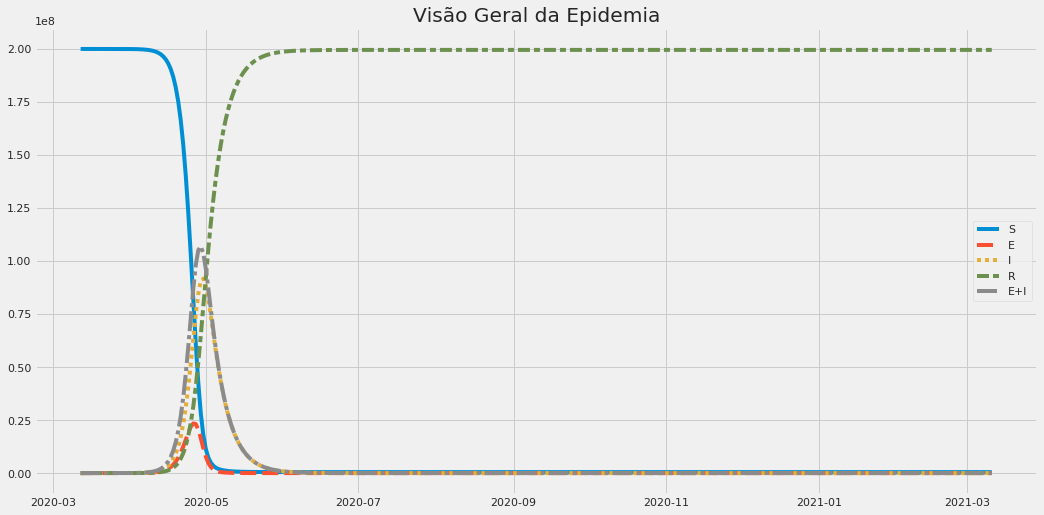

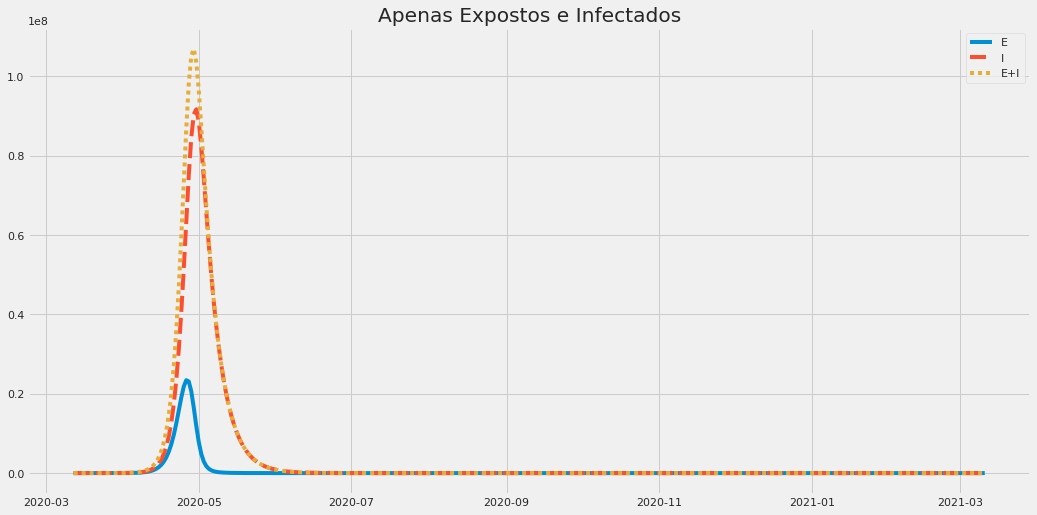

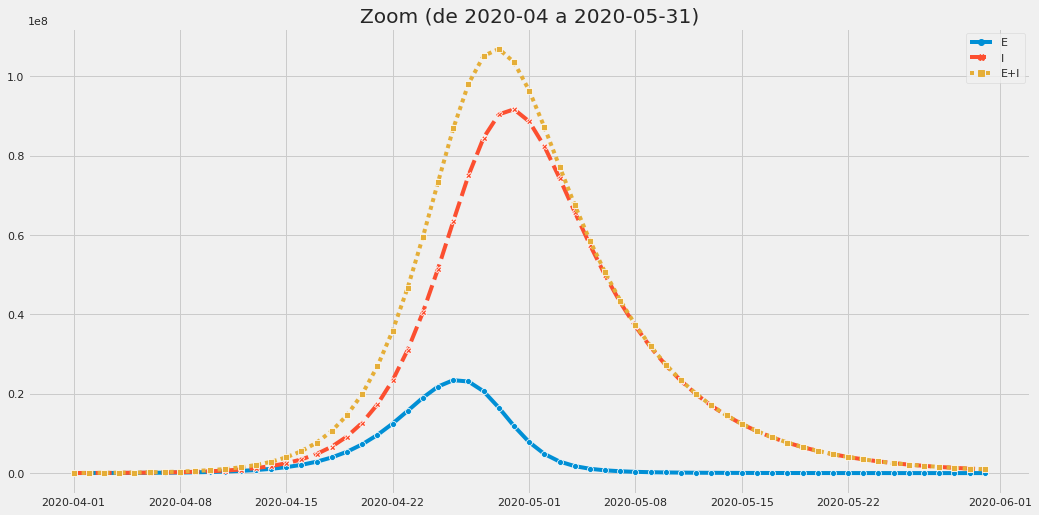

<Figure size 1152x576 with 0 Axes>

In [32]:
df_simulation_data = simulate(S=population_size - initially_infected, 
                              E =initially_infected, 
                              I=0, 
                              R=0, 
                              alpha=alpha, beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date,
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e, 
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta)

plot_simulation_output(df_simulation_data, zoom_on='2020-04')
df_simulation_data.head()

Vejamos um exemplo agora de parâmetro dinâmico. Vamos definir o parâmetro *beta* como 0.3 nos primeiros 30 dias, 0.25 nos 60 dias seguintes e 0.2 daí em diante.

In [21]:
beta = dynamic_parameter([(0.3, 30), 
                          (0.1, 60), 
                          (0.05, epidemic_duration_in_days)], min_length=epidemic_duration_in_days)


,S,E,E_delta,I,I_delta,R,E+I
2020-03-12,1.999999e+08,52.000000,0.000000,0.000000,0.000000,0.000000,52.000000
2020-03-13,1.999999e+08,36.400000,0.000000,15.600000,15.600000,0.000000,52.000000
2020-03-14,1.999999e+08,30.159999,4.679999,26.052000,10.920000,0.468000,56.211999
2020-03-15,1.999999e+08,28.927597,7.815598,34.318440,9.048000,1.249560,63.246037
2020-03-16,1.999999e+08,30.544846,10.295529,41.967166,8.678279,2.279113,72.512012


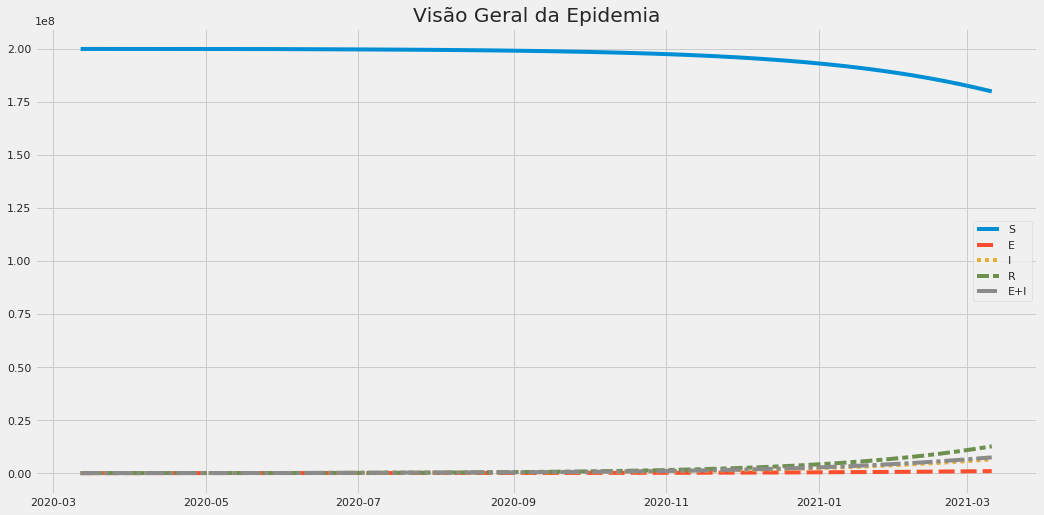

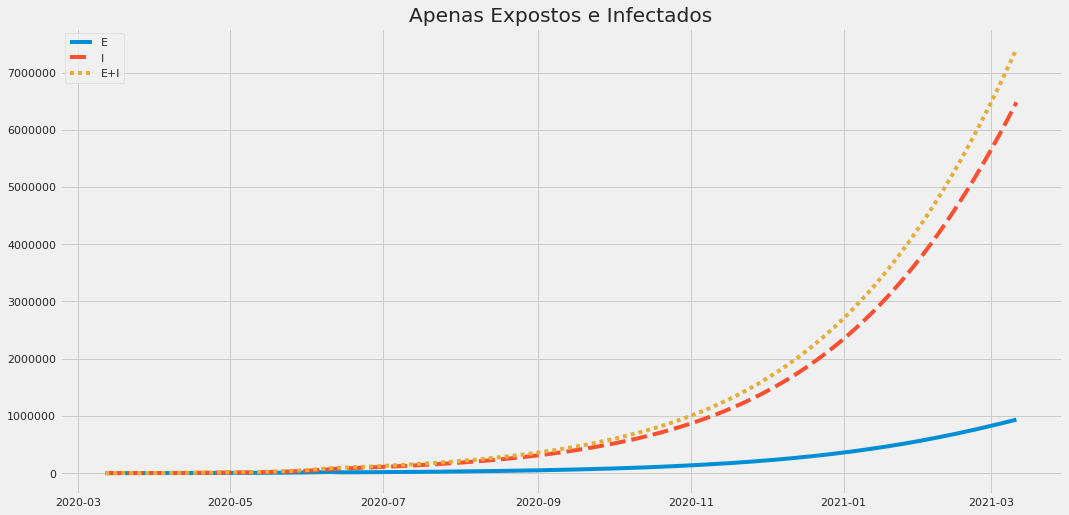

<Figure size 1152x576 with 0 Axes>

In [22]:
df_simulation_data = simulate(S=population_size - initially_infected, 
                              E =initially_infected, 
                              I=0, 
                              R=0, 
                              alpha=alpha, beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date,
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e, 
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta)

plot_simulation_output(df_simulation_data)
df_simulation_data.head()

## Calibragem de Parâmetros

Podemos agora confrontar os modelos acima com dados reais observados e, assim, encontrar os parâmetros que melhor aproximam a realidade. Vamos empregar dados do [Our World in Data](https://ourworldindata.org/coronavirus-source-data ).

In [23]:
df_data = pd.read_csv('../data/ourworldindata.org/coronavirus-source-data/full_data.csv', parse_dates=['date'])

Selecionemos apenas dados sobre o Brasil.

,new_cases,new_deaths,total_cases,total_deaths
date,,,,
2020-03-24,345,9,1891,34
2020-03-25,310,12,2201,46
2020-03-26,232,11,2433,57
2020-03-27,482,20,2915,77
2020-03-28,502,15,3417,92


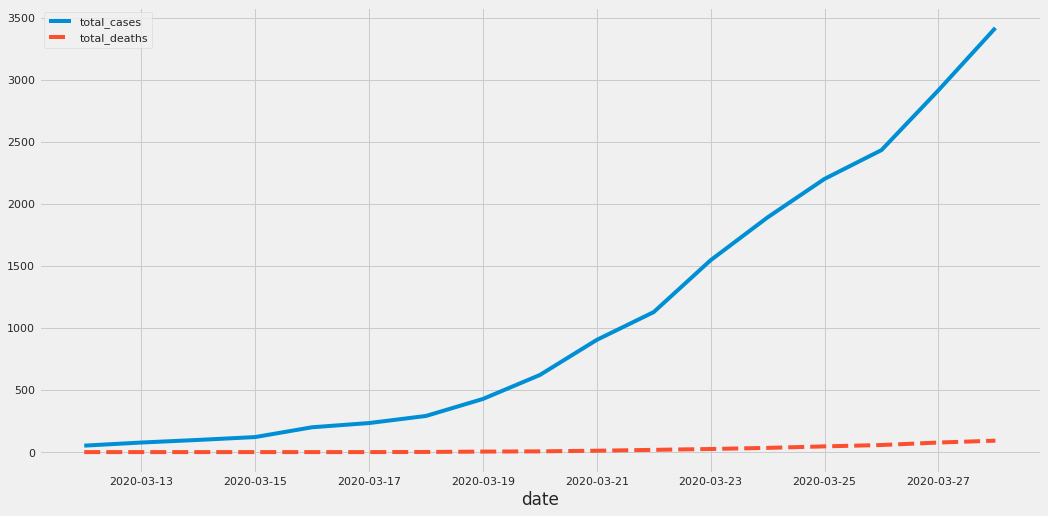

In [24]:
df_data_br = df_data[df_data['location']=='Brazil'].copy().set_index(['date']).drop('location', axis=1)
df_data_br = df_data_br[epidemic_start_date:]

sns.lineplot(data=df_data_br[['total_cases', 'total_deaths']])
df_data_br.tail()

Enriqueçamos esses dados com algumas suposições.

In [25]:
df_data_br['total_cases_ESTIMATED'] = (df_data_br['total_deaths'] / 0.05).shift(-10)
df_data_br['total_cases_ESTIMATED_2'] = 10 * df_data_br['total_cases']

df_data_br

,new_cases,new_deaths,total_cases,total_deaths,total_cases_ESTIMATED,total_cases_ESTIMATED_2
date,,,,,,
2020-03-12,18,0,52,0,360.0,520
2020-03-13,25,0,77,0,500.0,770
2020-03-14,21,0,98,0,680.0,980
2020-03-15,23,0,121,0,920.0,1210
2020-03-16,79,0,200,0,1140.0,2000
2020-03-17,34,0,234,0,1540.0,2340
2020-03-18,57,1,291,1,1840.0,2910
2020-03-19,137,3,428,4,NaN,4280
2020-03-20,193,2,621,6,NaN,6210


### Com Parâmetros Constantes

Suponhamos que os parâmetros do modelo sejam constantes, ou seja, que não haja mudanças de comportamento ou políticas ao longo da epidemia.

Faremos a busca de parâmetros empregando a biblioteca [hyperopt](https://github.com/hyperopt/hyperopt). Para tanto, precisamos definir uma função objetivo a ser otimizada. Aqui, essa função executa uma simulação com os parâmetros (*alpha*, *beta* e *gamma*) sugeridos, obtém a curva de infecções resultante e calcula o erro absoluto médio com relação às datas para as quais temos as observações reais.

In [26]:
def objective_for_simulation(args):
    alpha, beta, gamma = args
    df_simulation_data = simulate(S=population_size - initially_infected, 
                              E=initially_infected,
                              I=0,
                              R=0, 
                              alpha=alpha,beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date, 
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e,  
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta)
    
    # run simulation
    df_simulation_data_filtered = df_simulation_data[df_simulation_data.index.isin(df_data_br.index.values)]
    
    df_diff_cases = df_data_br['total_cases_ESTIMATED_2'] - \
                               (df_simulation_data_filtered['I'] + df_simulation_data_filtered['E'])

    values = df_diff_cases.dropna().values

    mae = np.mean(abs(values)) #mean absolute error

    return mae

Definimos então o espaço de busca dos parâmetros e efetivamente executamos a busca.

In [27]:
space = (hyperopt.hp.uniform('alpha', 0.0, 1.0), hyperopt.hp.uniform('beta', 0.0, 1.0), hyperopt.hp.uniform('gamma', 0.0, 1.0))

best = hyperopt.fmin(objective_for_simulation, space, algo=hyperopt.tpe.suggest, max_evals=300)

print("Best parameters found:", best)

100%|██████████| 300/300 [00:05<00:00, 53.28trial/s, best loss: 4774.266427489153] 
Best parameters found: {'alpha': 0.9297661164802022, 'beta': 0.9750422904261485, 'gamma': 0.053204052260669106}


Podemos então executar o modelo com os parâmetros encontrados e examinar as curvas de progressão da epidemia.

,S,E,E_delta,I,I_delta,R,E+I
2020-03-16,1.999998e+08,91.963110,88.362015,133.474086,47.671798,10.009963,225.437196
2020-03-17,1.999996e+08,136.601652,130.142726,211.876907,85.504183,17.111326,348.478559
2020-03-18,1.999994e+08,216.182632,206.588567,327.611784,127.007587,28.384036,543.794416
2020-03-19,1.999991e+08,334.617777,319.434431,511.180796,200.999286,45.814310,845.798572
2020-03-20,1.999986e+08,521.922178,498.420672,795.100177,311.116271,73.011200,1317.022355


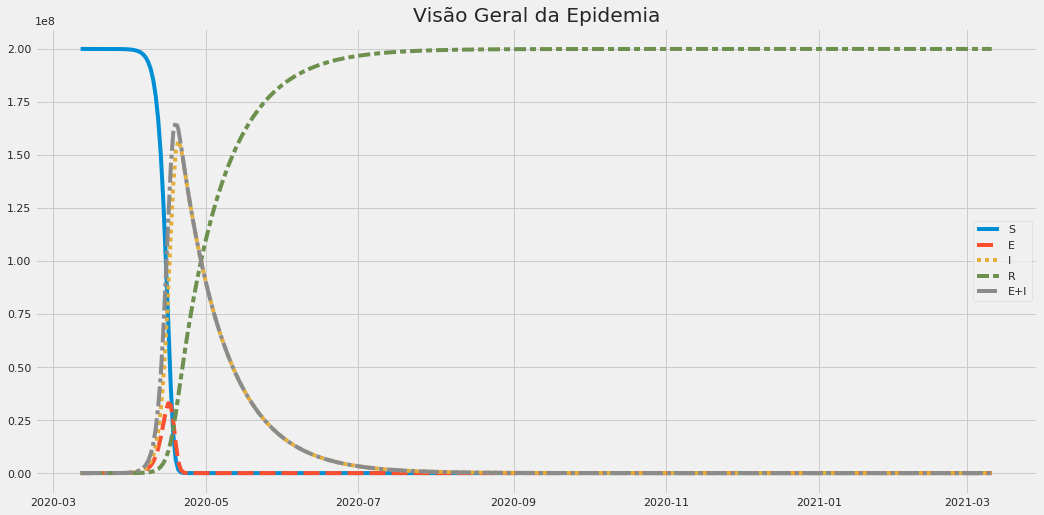

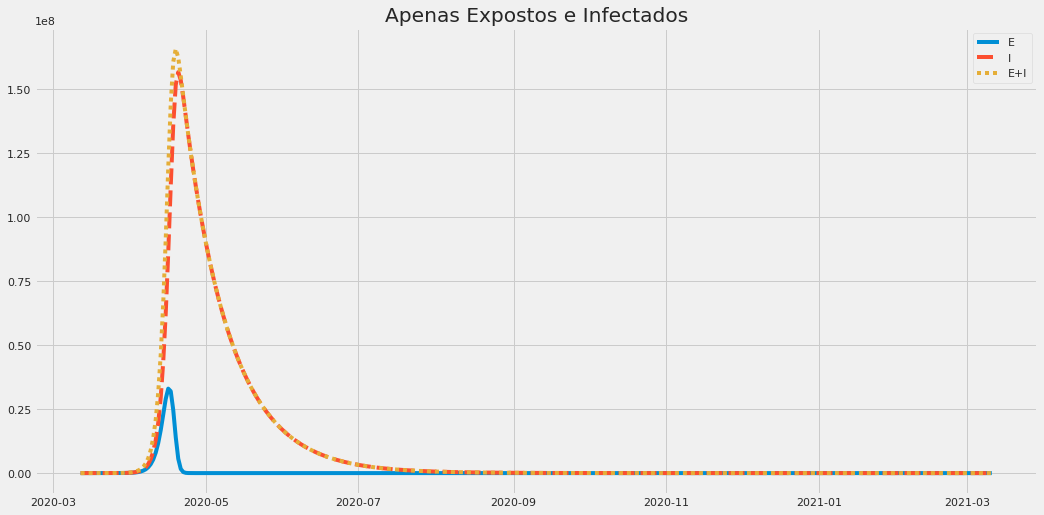

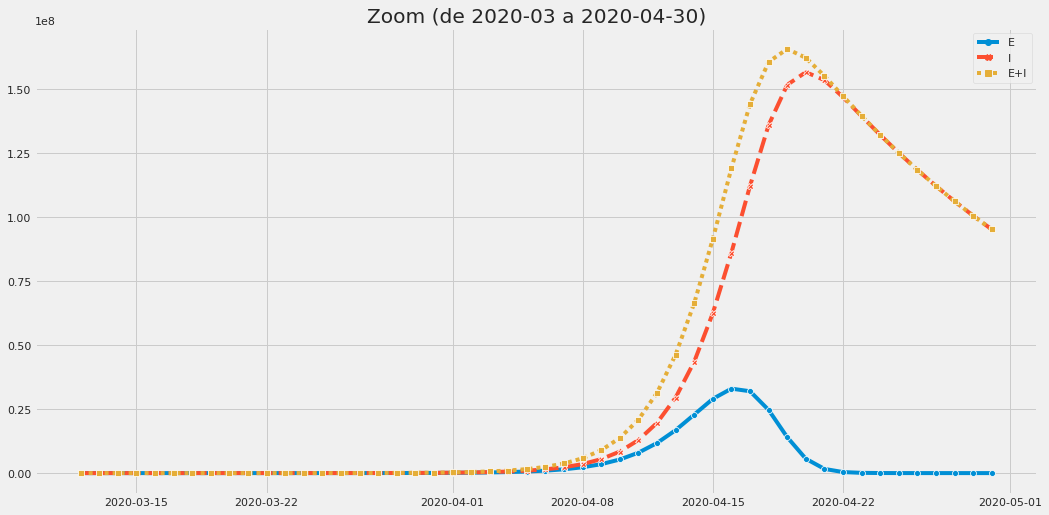

<Figure size 1152x576 with 0 Axes>

In [28]:
alpha = best['alpha']
beta  = best['beta']
gamma = best['gamma']

df_simulation_data = simulate(S=population_size - initially_infected, 
                              E=initially_infected,
                              I=0,
                              R=0, 
                              alpha=alpha, beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date, 
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e,
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta)

plot_simulation_output(df_simulation_data, zoom_on='2020-03')
df_simulation_data['2020-03-16':'2020-05-01'].head()

Salvemos os resultados.

In [29]:
df_simulation_data.to_csv(results_folder + 'seir_model_output.csv')

### Com Parâmetros Dinâmicos

Vamos experimentar agora introduzindo medidas de mitigação que reduzem o contágio após alguns dias iniciais com os parâmetros inferidos anteriormente.

In [30]:
alpha = dynamic_parameter([(best['alpha'], 5), 
                          (best['alpha']/3, 20), 
                          (best['alpha']/4, epidemic_duration_in_days)],
                         min_length=epidemic_duration_in_days)

beta = dynamic_parameter([(best['beta'], 5), 
                          (best['beta']/3, 20), 
                          (best['beta']/4, epidemic_duration_in_days)],
                         min_length=epidemic_duration_in_days)

Comparando as versões com e sem mitigação, temos o seguinte.

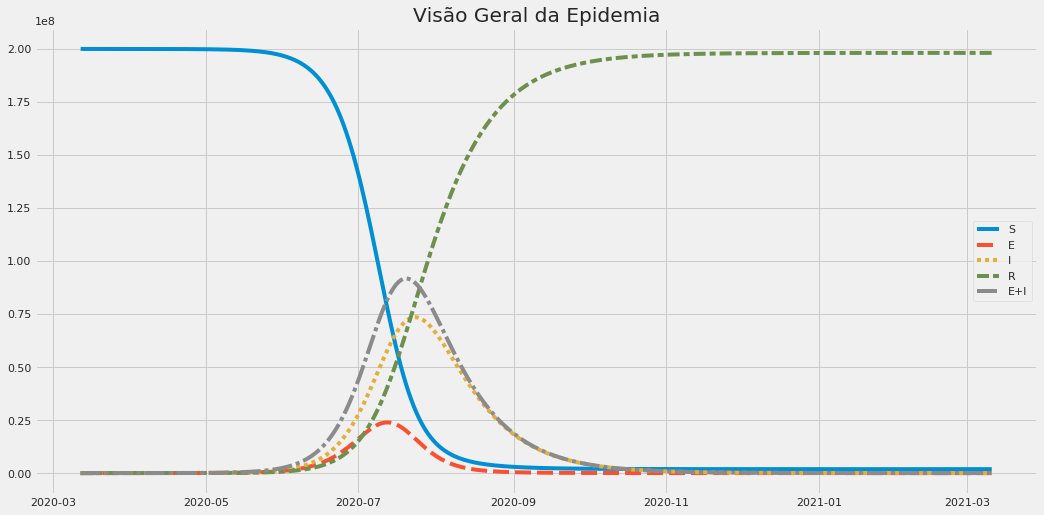

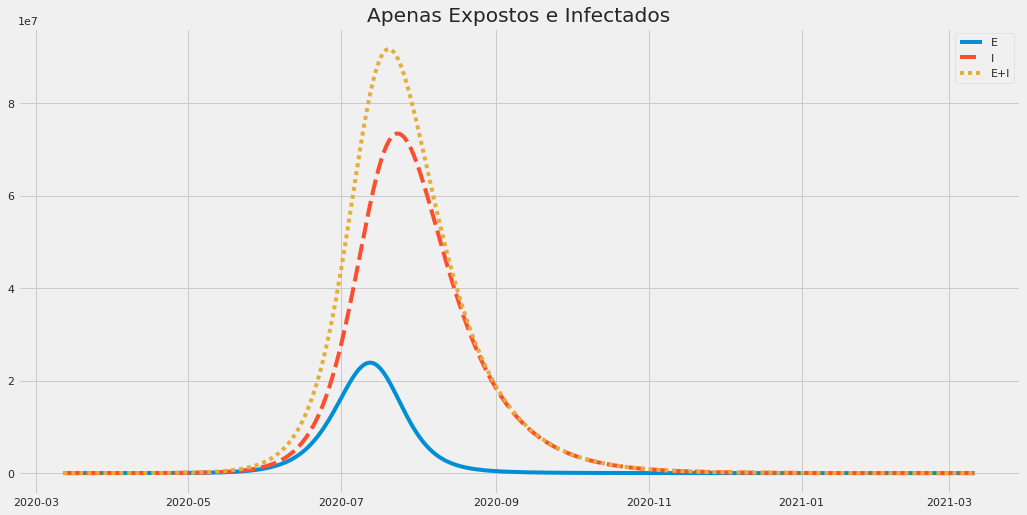

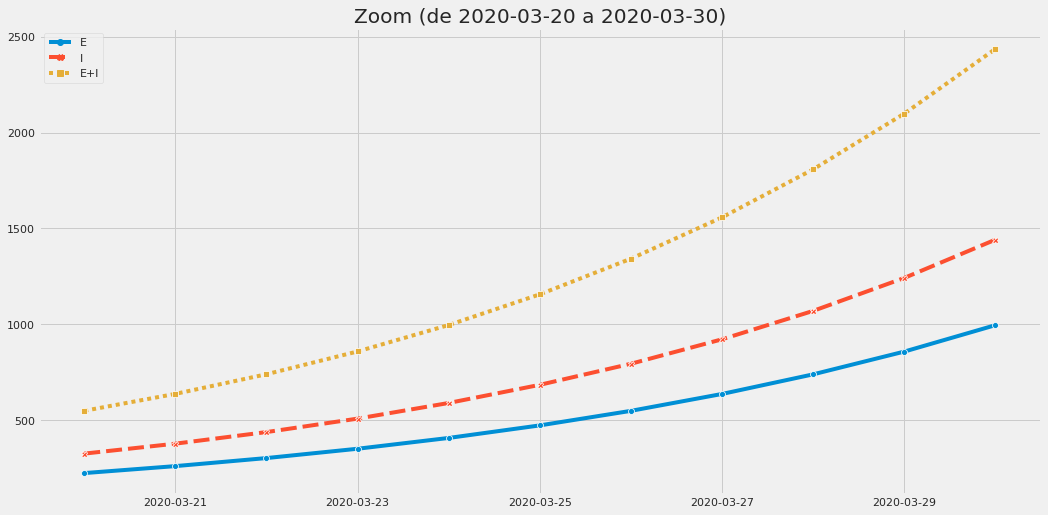

<Figure size 1152x576 with 0 Axes>

In [31]:
df_simulation_mitigation_data = simulate(S=population_size - initially_infected, 
                                          E=initially_infected,
                                          I=0,
                                          R=0, 
                                          alpha=alpha, beta=beta, gamma=gamma, 
                                          epidemic_start_date=epidemic_start_date, 
                                          epidemic_duration_in_days=epidemic_duration_in_days, 
                                          s_func=s, 
                                          e_func=e,
                                          i_func=i, 
                                          r_func=r,
                                          e_delta_func=e_delta,
                                          i_delta_func=i_delta)

plot_simulation_output(df_simulation_mitigation_data, zoom_on='2020-03-20', zoom_length=10)

Finalmente, comparemos os casos com e sem mitigação.

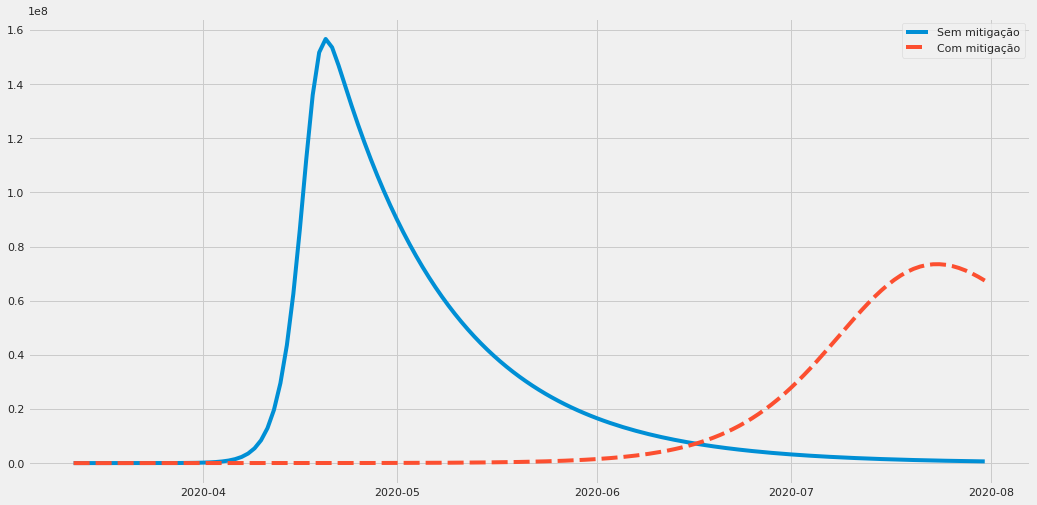

In [32]:
sns.lineplot(data=pd.concat([df_simulation_data['I'].rename('Sem mitigação'), 
                             df_simulation_mitigation_data['I'].rename('Com mitigação')], axis=1)['2020-03':'2020-07'])

Salvemos os resultados.

In [33]:
df_simulation_mitigation_data.to_csv(results_folder + 'seir_with_mitigation_model_output.csv')